O presente notebook tem por objetivo desenvolver um modelo de predição de preços a partir de uma base de dados de imóveis de uma plataforma de aluguel. O desenvolvimento seguirá as etapas de extração e entendimento de dados, análise exploratória, limpeza de dados, tratamento de dados, treinamento de modelos, teste de modelos e validação. As perguntas propostas no desafio serão respondidas integralmente no presente documento.

Desenvolvido por: Luiz Cláudio Macedo Januário

In [247]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle

Entrega 01 - Análise Exploratória

        - Extração, leitura e entendimento dos dados;

In [158]:
df = pd.read_csv("/Users/Luiz/.vscode/Pipelines/LightHouse/DataScience25.1/data/teste_indicium_precificacao.csv", encoding='unicode_escape')
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [74]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [75]:
print(df['bairro_group'].nunique())
print(df['bairro'].nunique())
print(df['room_type'].nunique())


5
221
3


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

        - Utilizando a função .describe e a função .info já podemos avaliar algumas grandezas (ex.: o preço é em em grande parte abaixo de 200 USD, mas os preços mais caros podem chegar até 10000 USD, indicando a existência de outliers) e a qualidade dos dados (existem valores nulos em duas colunas e valores "0" na coluna preço, indicando que o tratamento dos dados se faz necessário)
        - É possível também perceber que as variáveis categóricas 'bairro_group' e 'room_type' possuem poucos valores únicos, indicando que é possível uma tranformação em das mesmas em colunas dummies
        - A coluna 'bairro' possui muitas classes únicas, portano o método truncated one-hot encoding pode ser aplicado a ela afim de reduzir esse número antes da criação das colunas dummies
        - A coluna 'ultima_review' e a coluna 'reviews_por_mes' possuem valores nulos. Essas linhas serão excluídas, pois indicam imóveis que provavelmente nunca foram alugados ou foram alugados pouquíssimas vezes, portanto seu preço pode não ser representativo da realidade do mercado

In [159]:
#limpando os dados

df_clean = df.dropna() #removendo valores nulos
df_clean = df_clean[df_clean['price'] > 0] #removendo imóveis listados de graça
df_clean = df_clean[df_clean['price'] < 1201] #removendo imóveis com preço acima de 1200, já que a gigantesca maioria dos imoveis se encontra com preço abaixo de 300 USD
df_clean = df_clean[imovel['minimo_noites'] < 60] #removendo imóveis com mínimo de noites acima de 60, já que se trata de uma plataforma de alguel temporário de curta duração
df_clean = df_clean[df_clean['disponibilidade_365'] > 0] #removendo imóveis com disponibilidade 0
df_clean['ultima_review'] = pd.to_datetime(df_clean['ultima_review']) #convertendo a coluna ultima_review para datetime
df_clean['recencia'] = (df_clean['ultima_review'].max() - df_clean['ultima_review']).dt.days #calculando a recencia da ultima review em dias (como um inteiro)

In [130]:
df_clean.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,recencia
count,2.590600e+04,2.590600e+04,25906.000000,25906.000000,25906.000000,25906.000000,25906.000000,25906,25906.000000,25906.000000,25906.000000,25906.000000
mean,1.938453e+07,7.490166e+07,40.727386,-73.947560,143.852119,5.598935,38.363970,2019-03-22 18:28:49.267351296,1.821539,7.022890,170.105034,107.229985
min,2.595000e+03,2.571000e+03,40.506410,-74.244420,10.000000,1.000000,1.000000,2011-04-25 00:00:00,0.010000,1.000000,1.000000,0.000000
25%,9.529522e+06,7.475578e+06,40.686960,-73.982258,69.000000,1.000000,5.000000,2019-04-30 00:00:00,0.460000,1.000000,52.000000,10.000000
50%,2.086460e+07,3.560625e+07,40.721525,-73.952965,109.000000,2.000000,16.000000,2019-06-16 00:00:00,1.250000,1.000000,159.000000,22.000000
75%,2.953134e+07,1.319762e+08,40.763017,-73.929113,175.000000,4.000000,50.000000,2019-06-28 00:00:00,2.700000,3.000000,292.000000,69.000000
max,3.645581e+07,2.738417e+08,40.913060,-73.712990,1200.000000,59.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000,2996.000000
std,1.120101e+07,8.273756e+07,0.056968,0.051578,122.603250,8.525921,54.461879,NaN,1.808188,31.954463,124.086924,239.269365


In [160]:
#contabilizando quantas vezes cada bairro aparece no dataset e criando uma categoteria "outros" para bairros que aparecem menos de 500 vezes.
#isso é necessário para possibilidar o método dummies na categoria 'bairro'. 
#esse método é conhecido como truncated one_hot econding. 
#o requisito de 500 aparições serve para limitar o número de colunas dummies criadas, afim de evitar overfitting
classes_bairro = df_clean['bairro'].value_counts()
classes_bairro = classes_bairro[classes_bairro >= 500].index
df_clean['bairro_encoded'] = df_clean['bairro'].apply(lambda x: x if x in classes_bairro else 'Other')

In [161]:
#criando variáveis dummies para as variáveis categóricas

df_clean = pd.get_dummies(df_clean, columns=['bairro_group', 'room_type', 'bairro_encoded'])

In [162]:
#convertendo as variaveis dummy para inteiros 0 e 1
#essa etapa é necessária devido ao fato que o modelo XGBRegressor aceita apenas variáveis numpericas
boolean_columns = df_clean.select_dtypes(include=['bool']).columns
df_clean[boolean_columns] = df_clean[boolean_columns].astype(int)

In [163]:
df_clean.head()

,id,nome,host_id,host_name,bairro,latitude,longitude,price,minimo_noites,numero_de_reviews,...,bairro_encoded_Crown Heights,bairro_encoded_East Harlem,bairro_encoded_East Village,bairro_encoded_Harlem,bairro_encoded_Hell's Kitchen,bairro_encoded_Midtown,bairro_encoded_Other,bairro_encoded_Upper East Side,bairro_encoded_Upper West Side,bairro_encoded_Williamsburg
0,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,1,45,...,0,0,0,0,0,1,0,0,0,0
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,1,270,...,0,0,0,0,0,0,1,0,0,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Murray Hill,40.74767,-73.97500,200,3,74,...,0,0,0,0,0,0,1,0,0,0
6,5178,Large Furnished Room Near B'way,8967,Shunichi,Hell's Kitchen,40.76489,-73.98493,79,2,430,...,0,0,0,0,1,0,0,0,0,0
8,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Chinatown,40.71344,-73.99037,150,1,160,...,0,0,0,0,0,0,1,0,0,0


In [164]:
#criando uma matriz de correlações lineares entre todas as variáveis numéricas afim de entender um pouco melhor as relações entre elas
df_clean.select_dtypes(include=[np.number]).corr()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,...,bairro_encoded_Crown Heights,bairro_encoded_East Harlem,bairro_encoded_East Village,bairro_encoded_Harlem,bairro_encoded_Hell's Kitchen,bairro_encoded_Midtown,bairro_encoded_Other,bairro_encoded_Upper East Side,bairro_encoded_Upper West Side,bairro_encoded_Williamsburg
id,1.000000,0.602247,-0.007330,0.078434,0.005803,-0.136330,-0.450548,0.249417,0.094133,-0.138418,...,-0.022336,-0.006783,-0.030973,-0.042781,0.045770,0.031822,0.034342,-0.016980,-0.042498,-0.025231
host_id,0.602247,1.000000,0.001171,0.120432,0.016205,-0.110171,-0.233150,0.247186,0.144970,0.051032,...,-0.035795,-0.003982,-0.039618,-0.044827,0.069279,0.047980,0.079881,-0.026033,-0.030544,-0.076145
latitude,-0.007330,0.001171,1.000000,0.084686,0.050502,0.054765,-0.002532,-0.003177,0.006754,-0.018012,...,-0.170894,0.194286,-0.001955,0.384727,0.132799,0.077724,-0.188466,0.148423,0.195083,-0.070427
longitude,0.078434,0.120432,0.084686,1.000000,-0.256637,-0.111521,0.023213,0.116625,-0.117058,0.055665,...,0.011943,0.016981,-0.125650,-0.001343,-0.185916,-0.089539,0.156090,-0.027787,-0.093005,-0.024712
price,0.005803,0.016205,0.050502,-0.256637,1.000000,0.006785,-0.077047,-0.076919,0.100408,0.073524,...,-0.031131,-0.022429,0.060821,-0.047110,0.079318,0.182253,-0.067433,0.048894,0.068635,0.022427
minimo_noites,-0.136330,-0.110171,0.054765,-0.111521,0.006785,1.000000,-0.184404,-0.306113,0.177445,0.153478,...,-0.012423,-0.024124,-0.004870,-0.013276,0.033687,0.054767,-0.056827,0.101146,0.091695,-0.019137
numero_de_reviews,-0.450548,-0.233150,-0.002532,0.023213,-0.077047,-0.184404,1.000000,0.486804,-0.094924,0.043169,...,0.003634,0.031528,0.025211,0.028944,0.000353,-0.044459,-0.029900,-0.028275,-0.010519,0.011336
reviews_por_mes,0.249417,0.247186,-0.003177,0.116625,-0.076919,-0.306113,0.486804,1.000000,-0.055166,-0.061982,...,-0.011565,0.023913,-0.008005,-0.012615,0.044926,-0.023493,0.015052,-0.037903,-0.036787,-0.025597
calculado_host_listings_count,0.094133,0.144970,0.006754,-0.117058,0.100408,0.177445,-0.094924,-0.055166,1.000000,0.156572,...,-0.027473,-0.021109,-0.026199,-0.034715,0.028522,0.026028,0.068164,0.015387,0.000285,-0.046032
disponibilidade_365,-0.138418,0.051032,-0.018012,0.055665,0.073524,0.153478,0.043169,-0.061982,0.156572,1.000000,...,-0.007631,-0.031216,-0.049891,-0.014897,0.013325,0.041023,0.054379,0.013573,-0.005219,-0.067480


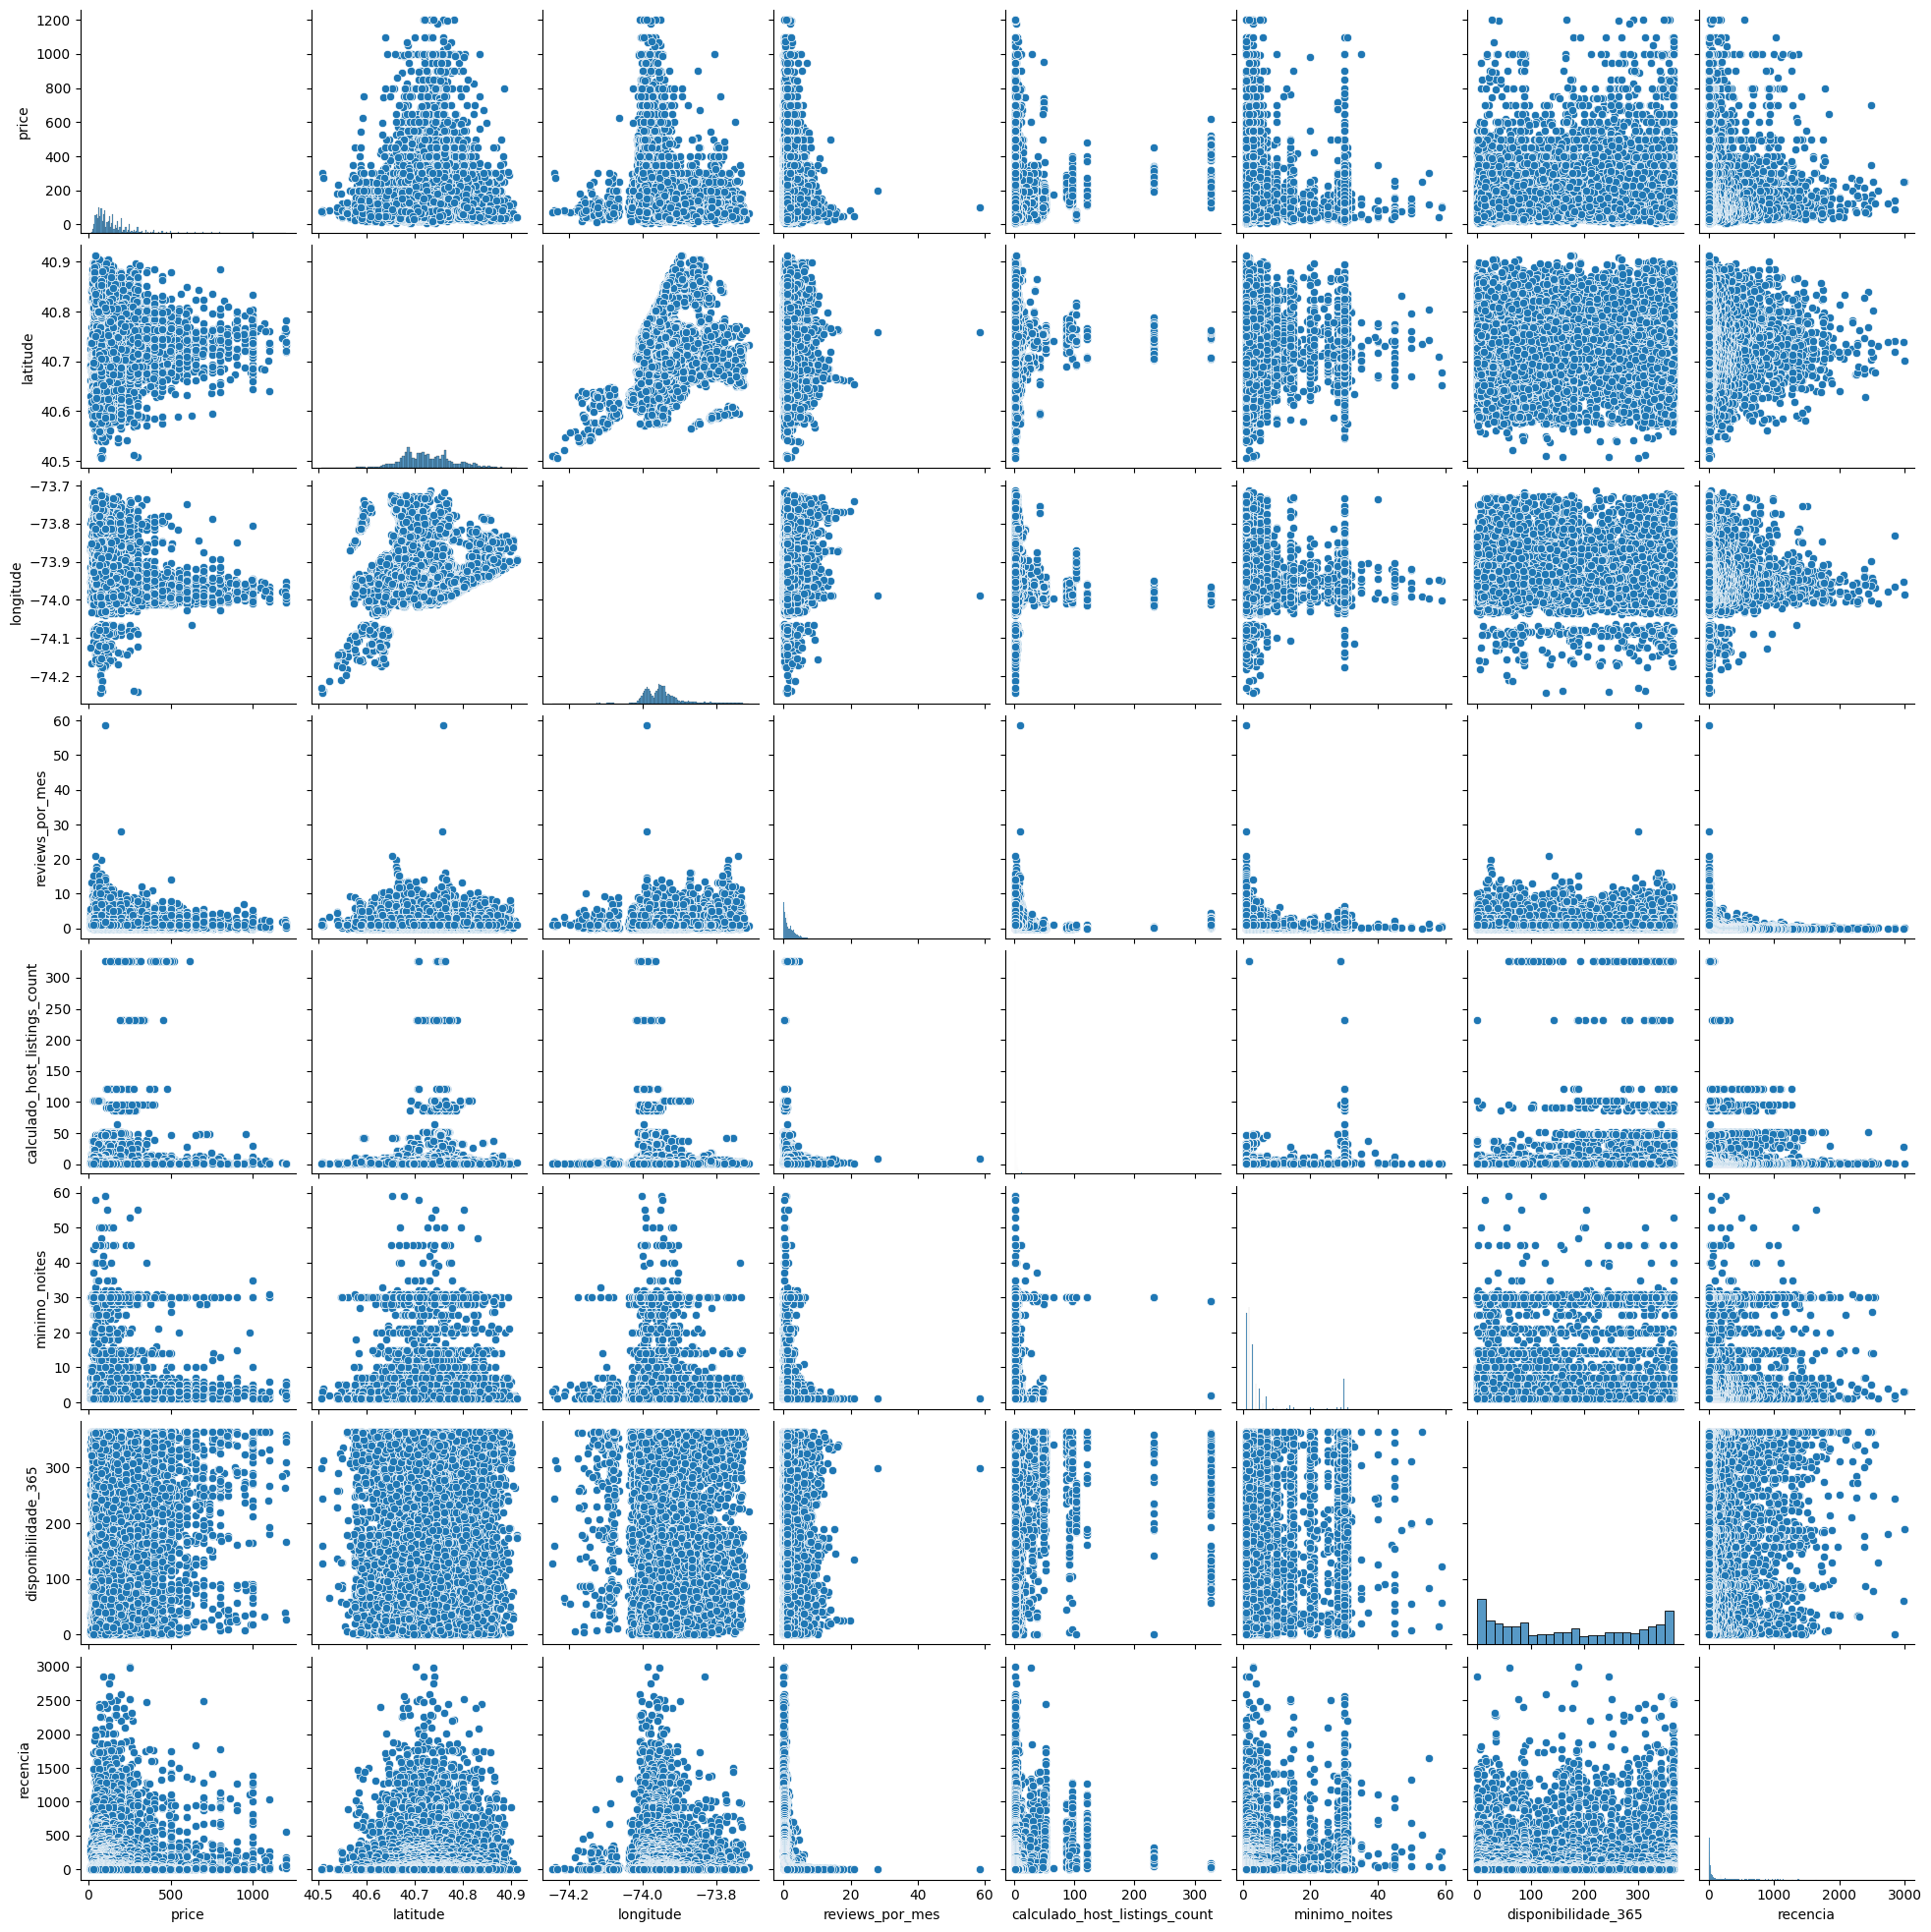

In [139]:
#criando plots das relações entre as variáveis numéricas para complementar o entendimento de suas relações
sns.pairplot(df_clean[['price', 'latitude', 'longitude', 'reviews_por_mes', 'calculado_host_listings_count', 'minimo_noites', 'disponibilidade_365', 'recencia']])

<Axes: >

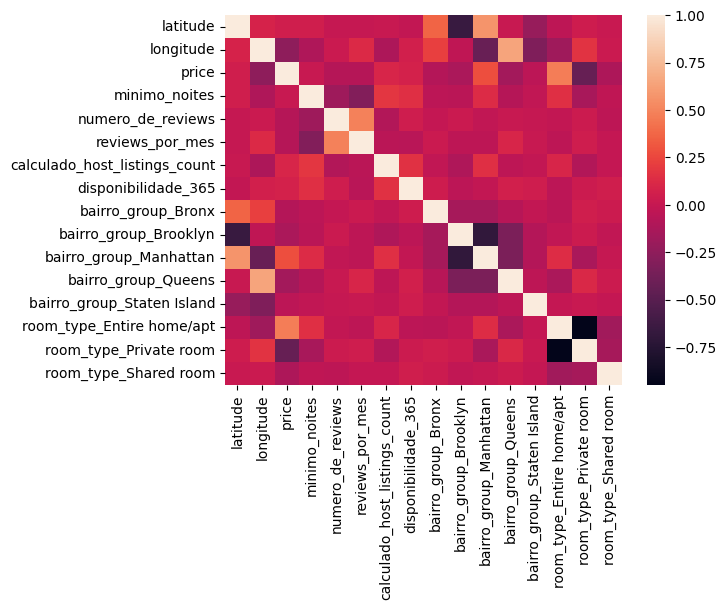

In [96]:
#criando um mapa de calor da matriz de correlações afim de facilitar a vizualização das relações
numeric_df = df_clean.select_dtypes(include=[np.number]).drop(columns=['id', 'host_id'])

sns.heatmap(numeric_df.corr(), )


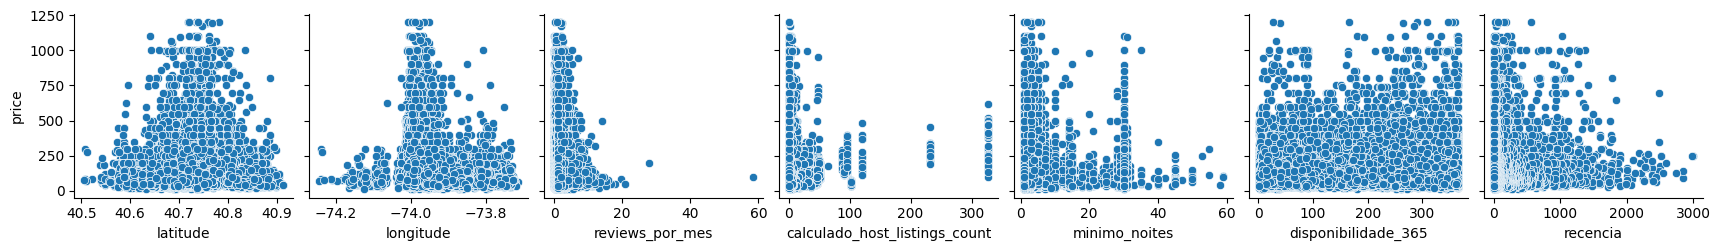

In [83]:
#criando plots apenas das relações entre as variáveis numéricas e o preço
sns.pairplot(df_clean, y_vars='price', x_vars=['latitude', 'longitude', 'reviews_por_mes', 'calculado_host_listings_count', 'minimo_noites', 'disponibilidade_365', 'recencia'])


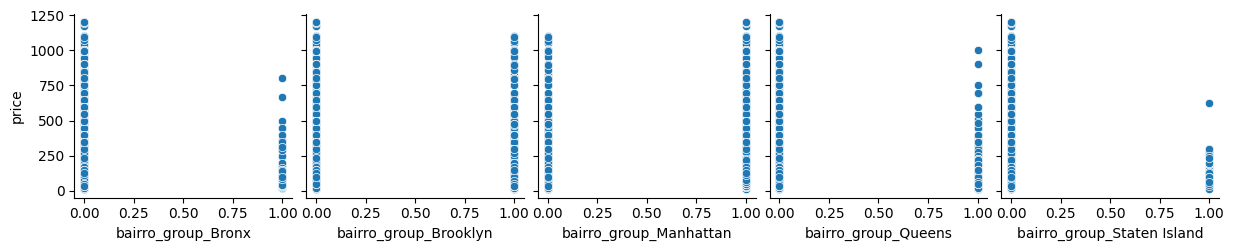

In [84]:
#criando plots apenas das relações entre os grupos de bairros e o preço
sns.pairplot(df_clean, y_vars='price', x_vars=['bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan', 'bairro_group_Queens', 'bairro_group_Staten Island'])

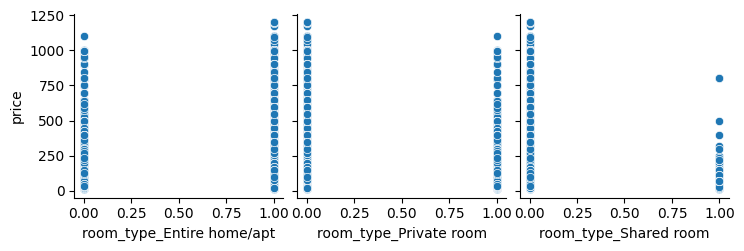

In [85]:
#criando plots apenas das relações entre os tipos de imóvel e o preço
sns.pairplot(df_clean, y_vars='price', x_vars=['room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room'])

C:\Users\Luiz\AppData\Local\Temp\ipykernel_932\2379420078.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alto_preco['nome_processado'] = df_alto_preco['nome'].apply(processar_texto)


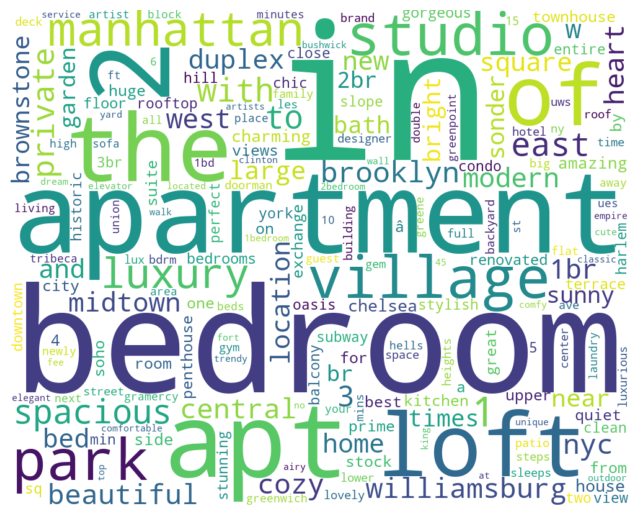

In [28]:

#utilizando o método wordcloud para vizualizar a recorrência de palavras entre os nomes dos imóveis mais caros
df_alto_preco = df_clean[df_clean['price'] > df_clean['price'].quantile(0.75)] #definindo como imóveis caros aqueles no ultimo quartil de preço

def processar_texto(texto): #função que transforma todo o texto em minúsculo e remove caracteres especiais
    texto = texto.lower()
    texto = ''.join(char for char in texto if char.isalnum() or char.isspace())
    return texto


#criando uma coluna com os nomes processados e criando uma variavel com todas as palavras contidas nessa coluna
df_alto_preco['nome_processado'] = df_alto_preco['nome'].apply(processar_texto)
palavras = ' '.join(df_alto_preco['nome_processado'])
#contando o número de ocorrência de cada palavra
contagem_palavras = Counter(palavras.split())

#aplicando o método wordcloud
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate_from_frequencies(contagem_palavras)

plotando o método wordcloud
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

        - A análise exploratória inicial demonstra que os valores de correlação linear entre as grandezas do banco de dados são relativamente fracos, o que dificulta uma análise superficial robusta. Alguns insights que puderam ser observados até o momento:
          - O gráfico de 'longitude' x 'latitude' forma o contorno perfeito da cidade de NY, portanto sabemos que a plataforma possui cobertura completa da cidade em termos de localizações disponíveis para aluguel;
          - Existe uma correlação linear negativa entre o preço por noite e a longitude do imóvel, indicando que regiões da cidade com baixa longitude são mais valorizadas;
          - Existe uma relação não-irrelevante ente o número de reviews e o preço;
          - O maior preditor de preço aparenta ser o tipo de imóvel, com apartamentos divididos tendo os menores preços em média;

Entrega 02 - Perguntas Propostas

    - Pergunta a.)Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
        Resposta: O bairro de Manhattan é o que possui a maior correlação com altos preços (apresentando um score de 0.282377, o único positivo), portanto é o mais indicado para investimento a princípio, no entanto o valor de venda do imóvel também deverá ser levado em conta para avaliar com precisão o valor do investimento.
    
    - Pergunta b.)O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
        Resposta: Analisando apenas as pontuações de correlação linear nenhuma das duas variáveis aparentam exercer grande influência sobre o preço do aluguel, no entanto a análise gráfica sugere que existe algum tipo de correlação sim. Para o número mínimo de noites existe uma clara tendência de queda do preço com o aumento do número mínimo, algo que parece concordar perfeitamente com a prática padrão do mercado de oferecer "descontos" para compras maiores, ou seja, quanto mais dias o inquilino precisa "comprar", melhores os preços; Esta tendência é interrompida no entanto quando o número mínimo de noites atinge a marca de 30 noites (1 mês), indicando que os hosts tendem a precificar acima do preço esperado quando o aluguel é similar ao regime mensal mais comum no mercado tradicional de aluguéis. Isso pode ser um indicador de "contaminação" das práticas e preços do mercado tradicional de aluguel de imóveis no mercado de aluguel de curta duração. Quanto à disponibilidade, aparenta existir uma pequena correlação entre uma maior disponibilidade e um preço maior, possivelmente indicando diferentes perfis de utilização dos imóveis: imóveis utilizados puramente para fins lucrativos (disponíveis o ano inteiro) tendem a ter preços mais altos, enquanto imóveis alugados apenas em datas específicas (pouca disponibilidade) tendem a ter preços mais baixos, já que seu propóstito para o proprietário vai além do lucro gerado pelo aluguel. Este efeito muito provavelmente é contrabalanceado pelo efeito da oferta e demanda, tendo em vista que a baixa disponibilidade gera uma escassez de oferta do imóvel, e portanto, seu preço tende a subir levemente (principalmente se o imóvel for alugado apenas em feriados e datas de alta demanda). Dessa forma, os efeitos positivos e negativos da disponibilidade acabam quase que se equilibrando e o seu efeito na precificação se torna bastante tênue.
    
    - Pergunta c.)Existe algum padrão no texto do nome do local para lugares de mais alto valor?
        Resposta: Com base na nuvem de palavras gerada anteriormente, podemos identificar que entre as propriedades no último quartil de preço, as palavras "in", "bedroom", "apartment", "2", "park", "luxury", "loft", "the" e "Manhattan" são as mais recorrentes.

Entrega 03 - Desenvolvimento do Modelo Preditivo

    Afim de prever o preço de aluguel de um imóvel dadas as demais características do mesmo, eu desenvolverei um modelo de machine learning com XGBoost.
    As transformações necessárias para a aplicação desse modelo serão as seguintes para cada coluna: id – será ignorado, já que é apenas um identificador único e sem relação com o preço; nome - apesar de haver uma correlação entre certas palavras-chave e a precificação, a introdução de um método capaz de traduzir nomes em dados relevantes para o treinamento do modelo seria demasiadamente custosa em termos de complexidade computacional e horas-trabalho em função de um ganho possivelmente marginal ou até uma perda em precisão dos resultados; host_id - ignorado pelo mesmo motivo da coluna "id"; host_name – ignorado pelo mesmo motivo da coluna "id", bairro_group - será ignorado, pois suas colunas dummies é que serão utilizadas; bairro - será ignorado, pois suas colunas dummies é que serão utilizadas; latitude - sofrerá um processo de normalização de seus valores; longitude - sofrerá um processo de normalização de seus valores;  room_type – será ignorado, pois suas colunas dummies é que serão utilizadas; price - Sofrerá um processo de normalização dos valores a variável-alvo do modelo; minimo_noites - sofrerá um processo de normalização de seus valores; numero_de_reviews - sofrerá um processo de normalização de seus valores; ultima_review - Será tranformada na coluna 'recencia' (contendo  diferença em dias entre a última review do imóvel e a última review da base de dados) que será utilizada no treinamento do modelo; reviews_por_mes - será utilizada no treinamento do modelo; calculado_host_listings_count - será utilizada no treinamento do modelo; disponibilidade_365 - será utilizada no treinamento do modelo.
    A criação de colunas dummies para as variáveis categóricas é necessária devido ao modo de funcionamento do modelo XGBoost, que trabalha melhor quando treinado com variáveis numéricas (as variáveis booleanas serão transformadas em valores inteiros pelo mesmo motivo). A normalização de valores será realizada para evitar que diferenças nas ordens de grandeza de diferentes variáveis confundam o modelo durante a etapa de treinamento. 
    O problema em questão é um problema de regressão. 
    Em minha experiência, o modelo XGBoost tende a ser um dos modelos de melhor performance em problemas de regressão devido a sua alta versatilidade, por isso foi o modelo escolhido para a solução em questão. Vale ressaltar que para um projeto com prazo mais extenso seria possível treinar e testar uma vasta quantidade de modelos diferentes e comparar seus resultado afim de implementar apenas aquele com melhor performance.
    As medidas de avaliação do modelo utilizadas serão r^2 e mse, pois são as medidas mais comuns e recomendadas na literatura quando se trata de problemas de regressão.

    

In [165]:
#criando uma coluna 'aluguel_mensal' indicando para o modelo que o preço pode ser 'contaminado' pelo efeito citado na resposta da pergunta b do item 2. 
#a ideia é facilitar que o modelo identifique e aprenda esse padrão

df_clean['aluguel_mensal'] = df_clean['minimo_noites'].apply(lambda x: 1 if x == 30 else 0)


In [166]:
#normalizando as variáveis numéricas
scaler = MinMaxScaler()
var_numericas = ['latitude', 'longitude', 'reviews_por_mes', 'calculado_host_listings_count', 'minimo_noites', 'disponibilidade_365', 'recencia', 'price']
df_norm = df_clean.copy()
df_norm[var_numericas] = scaler.fit_transform(df_clean[var_numericas])

In [167]:
#Removendo as colunas que não serão utilizadas no treinemento do modelo

df_variaveis = df_norm.drop(columns=['id','host_id','nome','host_name','ultima_review','bairro'])

In [168]:
#serparando as variáveis independentes da variável-alvo
df_x = df_variaveis.drop(columns='price').copy()
df_y = df_variaveis['price'].copy()

In [169]:
#Separando a base de teste e de treino

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=72)

In [170]:
#criando e treinando o modelo na base de treino

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [171]:
#testando o modelo com a base de teste
y_previsao = xgb.predict(X_test)
y_check_overfit = xgb.predict(X_train)

r = r2_score(y_test, y_previsao)
mse = mean_squared_error(y_test, y_previsao)

r_overfit = r2_score(y_train, y_check_overfit)
mse_overfit = mean_squared_error(y_train, y_check_overfit)

print('r= ',r)
print('mse= ',mse)
print('r_overfit= ',r_overfit)
print('mse_overfit= ',mse_overfit)

r=  0.4747556573480014
mse=  0.006512851918942055
r_overfit=  0.7478561421993601
mse_overfit=  0.002625848942765005


In [206]:
#optimizando parametros do modelo

#criando um grid de parametros
grid_parametros = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'eval_metric': ['rmse', 'mae'],
    'early_stopping_rounds': [5,10,20]
}

#buscando a melhor combinação de parametros do grid com o método randomized search
random_search = RandomizedSearchCV(XGBRegressor(), param_distributions=grid_parametros, n_iter=80, scoring='r2', cv=3, verbose=1, random_state=23, n_jobs=-1, error_score='raise')


In [209]:
random_search.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    verbose=True)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[0]	validation_0-mae:0.06889
[1]	validation_0-mae:0.06846
[2]	validation_0-mae:0.06806
[3]	validation_0-mae:0.06769
[4]	validation_0-mae:0.06747
[5]	validation_0-mae:0.06707
[6]	validation_0-mae:0.06669
[7]	validation_0-mae:0.06633
[8]	validation_0-mae:0.06596
[9]	validation_0-mae:0.06562
[10]	validation_0-mae:0.06534
[11]	validation_0-mae:0.06497
[12]	validation_0-mae:0.06463
[13]	validation_0-mae:0.06430
[14]	validation_0-mae:0.06397
[15]	validation_0-mae:0.06363
[16]	validation_0-mae:0.06329
[17]	validation_0-mae:0.06297
[18]	validation_0-mae:0.06267
[19]	validation_0-mae:0.06236
[20]	validation_0-mae:0.06207
[21]	validation_0-mae:0.06177
[22]	validation_0-mae:0.06152
[23]	validation_0-mae:0.06122
[24]	validation_0-mae:0.06094
[25]	validation_0-mae:0.06065
[26]	validation_0-mae:0.06038
[27]	validation_0-mae:0.06009
[28]	validation_0-mae:0.05984
[29]	validation_0-mae:0.05957
[30]	validation_0-mae:0.05931
[31]	validation_0-

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'early_stopping_rounds': [5, 10, 20],
                                        'eval_metric': ['rmse', 'mae'],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [7, 9, 11],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 300, 400, 500],
                                        'subsample': [0.6, 0.7, 0.8]},
                   random_state=23, scoring='r2', verbose=1)

In [210]:
#treinando o modelo otimizado
xgb_otimizado = XGBRegressor(**random_search.best_params_)
xgb_otimizado.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-mae:0.06889
[1]	validation_0-mae:0.06846
[2]	validation_0-mae:0.06806
[3]	validation_0-mae:0.06769
[4]	validation_0-mae:0.06747
[5]	validation_0-mae:0.06707
[6]	validation_0-mae:0.06669
[7]	validation_0-mae:0.06633
[8]	validation_0-mae:0.06596
[9]	validation_0-mae:0.06562
[10]	validation_0-mae:0.06534
[11]	validation_0-mae:0.06497
[12]	validation_0-mae:0.06463
[13]	validation_0-mae:0.06430
[14]	validation_0-mae:0.06397
[15]	validation_0-mae:0.06363
[16]	validation_0-mae:0.06329
[17]	validation_0-mae:0.06297
[18]	validation_0-mae:0.06267
[19]	validation_0-mae:0.06236
[20]	validation_0-mae:0.06207
[21]	validation_0-mae:0.06177
[22]	validation_0-mae:0.06152
[23]	validation_0-mae:0.06122
[24]	validation_0-mae:0.06094
[25]	validation_0-mae:0.06065
[26]	validation_0-mae:0.06038
[27]	validation_0-mae:0.06009
[28]	validation_0-mae:0.05984
[29]	validation_0-mae:0.05957
[30]	validation_0-mae:0.05931
[31]	validation_0-mae:0.05906
[32]	validation_0-mae:0.05882
[33]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [211]:
#testando o modelo otimizado com a base de teste
y_previsao_otimizado = xgb_otimizado.predict(X_test)
y_check_overfit_otimizado = xgb_otimizado.predict(X_train)

r_otimizado = r2_score(y_test, y_previsao_otimizado)
mse_otimizado = mean_squared_error(y_test, y_previsao_otimizado)

r_overfit_otimizado = r2_score(y_train, y_check_overfit_otimizado)
mse_overfit_otimizado = mean_squared_error(y_train, y_check_overfit_otimizado)

print('r= ',r_otimizado)
print('mse= ',mse_otimizado)
print('r_overfit= ',r_overfit_otimizado)
print('mse_overfit= ',mse_overfit_otimizado)

r=  0.5040000664272837
mse=  0.006150231153093042
r_overfit=  0.7705865376566078
mse_overfit=  0.0023891325483992305


    - Com os resultados apresentados acima podemos perceber que o modelo otimizado apresenta um valor de r_quadrado relativamente baixo e bastante overfiting apesar das boa práticas empregadas. Isso provavelmente indica que esse problema se trata de um caso de alta complexidade de previsão. Outros modelos de regressão e metodologias de tratamento de dados foram testados em um notebook secundário, os resultados apresentados neste notebook são os melhores resultados encontrados.

Entrega 04 - Realizando Previsão

    Dados o seguinte imóvel:
        {'id': 2595,
        'nome': 'Skylit Midtown Castle',
        'host_id': 2845,
        'host_name': 'Jennifer',
        'bairro_group': 'Manhattan',
        'bairro': 'Midtown',
        'latitude': 40.75362,
        'longitude': -73.98377,
        'room_type': 'Entire home/apt',
        'minimo_noites': 1,
        'numero_de_reviews': 45,
        'ultima_review': '2019-05-21',
        'reviews_por_mes': 0.38,
        'calculado_host_listings_count': 2,
        'disponibilidade_365': 355}
        
    O modelo otimizado será utilizado para prever seu preço


In [245]:
imovel = pd.DataFrame([{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}])

In [241]:
imovel.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2019-05-21,0.38,2,355


In [246]:

imovel['ultima_review'] = pd.to_datetime(imovel['ultima_review']) #convertendo a coluna ultima_review para datetime
imovel['recencia'] = (imovel['ultima_review'].max() - imovel['ultima_review']).dt.days #calculando a recencia da ultima review em dias (como um inteiro)
imovel['bairro_encoded'] = imovel['bairro'].apply(lambda x: x if x in classes_bairro else 'Other')
imovel = pd.get_dummies(imovel, columns=['bairro_group', 'room_type', 'bairro_encoded'])
boolean_columns = imovel.select_dtypes(include=['bool']).columns
imovel[boolean_columns] = imovel[boolean_columns].astype(int)
imovel['aluguel_mensal'] = imovel['minimo_noites'].apply(lambda x: 1 if x == 30 else 0)
imovel['price'] = 0
imovel[var_numericas] = scaler.fit_transform(imovel[var_numericas])

for col in df_x.columns:
	if col not in imovel.columns:
		imovel[col] = 0
imovel_variaveis = imovel[df_x.columns]

imovel_preco = (xgb_otimizado.predict(imovel_variaveis) * (df_clean['price'].max() - df_clean['price'].min())) + df_clean['price'].min()

print('preço = ', imovel_preco)

preço =  [228.06602]


    - Segundo o modelo desenvolvido, o preço por noite do imóvel em questão é $228

Entrega 05 - salvando o modelo em .pkl

In [249]:
filename = 'modelo_predição_preço_XGB'
pickle.dump(xgb_otimizado, open(filename, 'wb'))

In [250]:
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.predict(imovel_variaveis)

array([0.18324876], dtype=float32)